### Introduction


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr

The cell below imports the original image

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

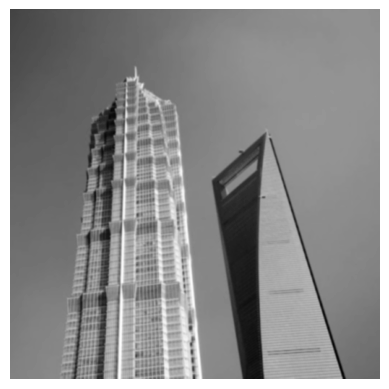

In [9]:
low_res_img = cv2.imread("buildings.jpg", cv2.IMREAD_GRAYSCALE)

smoothed_image = cv2.GaussianBlur(low_res_img, (5, 5), 1)

plt.imshow(smoothed_image, cmap = "gray")
plt.axis("off")

In [10]:
height, width = low_res_img.shape
print(f"The original image has a height of {height} pixels")
print(f"The original image has a width of {width} pixels")

The original image has a height of 512 pixels
The original image has a width of 512 pixels


Now we want to upscale the resolution of this image by upsampling the original image. There exist several techniques to perform this operation: we will opt for bicubic interpolation.

Bicubic interpolation compute the interpolation between a bunch of points. For upscaling we usually consider the two pixels that lay back and the two after along the same axis. We perform it first along rows and then along columns, forming a 4 x 4 grid.

The bicubic interpolation consists in a weighted average bewteen those pixels in the neighborhood. A really common way to assign those weights is the bicubic kernel (Mitchell-Netravali filter). The function to assign weights is defined in the cell below.

In [11]:
def bicubic_weight(x):
    """Computes the weight for bicubic interpolation."""
    x = abs(x) #compute the distance in terms of pixels
    if x <= 1: #if the pixel is very close, it gives a positive weight
        return (1.5 * x**3) - (2.5 * x**2) + 1 
    elif x < 2: #if the pixel is further, it gives a negative weight
        return (-0.5 * x**3) + (2.5 * x**2) - (4 * x) + 2
    else: #if the pixel is even further than 2, then it gives a 0 weight
        return 0

Now we define the one dimensional cubic interpolation for a row of the grid

In [12]:
def cubic_interpolation(p, x): #x correspond to the position in the grid of the point to interpolate
    """Interpolates a value using 4 known points (p) and position x."""
    return (p[0] * bicubic_weight(x + 1) + #first point of the row is far x (the nearest left old pixel distance + 1) in the row
            p[1] * bicubic_weight(x) + #second point of the row is the nearest left old pixel 
            p[2] * bicubic_weight(x - 1) + #third point of the row has a distance of (1 - left nearest pixel's distance) and it is the right nearest pixel
            p[3] * bicubic_weight(x - 2)) #fourh point of the row is far the same of the previous plus 1

Now, for each point in the new image rescaled, we build a grid and interpolate first along x-axis, then we apply a weight that depend on the shift on the y-axis (clearly this shift is identical for the same row)

In [13]:
def bicubic_interpolation(image, x, y):
    """Performs bicubic interpolation at non-integer coordinates (x, y)."""
    x0, y0 = int(x), int(y)  # Top left corner of the grid
    result = 0
    
    # Iterate over the 4×4 grid of neighboring pixels
    for i in range(-1, 3):
        row = [] #element in the same row
        for j in range(-1, 3):
            px = min(max(x0 + j, 0), image.shape[1] - 1) #ensures we do not get out of the border
            py = min(max(y0 + i, 0), image.shape[0] - 1) #ensures we do not get out of the border
            row.append(image[py, px]) #get the corresponding pixel of the grid from the old image
        
        result += cubic_interpolation(row, x - x0) * bicubic_weight(y - y0) #apply the interpolation along x and then apply a weight for y-shift
    
    return np.clip(result, 0, 255)

In [14]:
def resize_bicubic(image, scale_factor = 2):
    """Resizes an image using bicubic interpolation."""
    new_height = int(image.shape[0] * scale_factor) #scaled height
    new_width = int(image.shape[1] * scale_factor) #scaled width
    new_image = np.zeros((new_height, new_width)) #initialize the new image

    for i in range(new_height):
        for j in range(new_width):
            # Map new pixel to old image space
            old_x = j / scale_factor #new pixel in the old image x-position
            old_y = i / scale_factor #new pixel in the old image y-position
            new_image[i, j] = bicubic_interpolation(image, old_x, old_y)

    return new_image.astype(np.uint8)

Now we can rescale our image, applying any kind of rescale factor. Let's try with 2.

In [15]:
# Apply bicubic resizing
high_res_img = resize_bicubic(smoothed_image, scale_factor= 3)

# Show results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(low_res_img, cmap="gray")
ax[0].set_title("Low-Resolution Image")
ax[0].axis("off")

ax[1].imshow(high_res_img, cmap="gray")
ax[1].set_title("Upscaled with Bicubic Interpolation")
ax[1].axis("off")

plt.show()

KeyboardInterrupt: 

In [9]:
import numpy as np
"""
def householder_reflection(a):

    v = a.copy()
    v[0] += np.sign(a[0]) * np.linalg.norm(a)
    #v = v / np.linalg.norm(v)
    H = np.eye(len(a)) - 2 * (np.outer(v, v)/np.linalg.norm(v) **2)
    return H, v

def bidiagonalize(A):
   
    m, n = A.shape
    P = np.eye(m)  # Orthogonal matrix for column transformations
    H = np.eye(n)  # Orthogonal matrix for row transformations
    B = A.copy()  # Copy of A to hold the resulting bidiagonal matrix

    # Step 1: Apply Householder reflections to columns to create zeros below the diagonal.
    for k in range(min(m, n)):
        # Extract the vector a for the current column
        a = B[k:m, k]
        
        # Apply Householder reflection to zero out the entries below the pivot
        Hk, v = householder_reflection(a)
        
        # Update matrix B by applying Hk to the columns
        B[k:m, k:n] = Hk @ B[k:m, k:n]
        
        # Update P by applying the transpose of Hk
        P[:, k:m] = P[:, k:m] @ Hk.T

        # Step 2: Apply Householder reflections to rows to create zeros above the diagonal.
        if k < n - 1:
            b = B[k, k+1:n]
            
            # Apply Householder reflection to zero out the entries above the pivot
            Hk, v = householder_reflection(b)
            
            # Update matrix B by applying Hk to the rows
            B[k:m, k+1:n] = B[k:m, k+1:n] @ Hk.T
            
            # Update Q by applying the transpose of Hk
            H[k+1:n, :] = Hk @ H[k+1:n, :]
    
    return B, P, H
"""


In [16]:
import numpy as np

def householder_reflection_vector(x):
    """
    Dato un vettore x, costruisce il vettore v NORMALIZZATO
    da cui si ricava la riflessione di Householder:
        H = I - 2 vv^T
    tale che H x = +/- ||x|| e azzera le componenti di x al di sotto (o a destra).
    """
    # Evita problemi con x[0] = 0
    alpha = -np.sign(x[0] if x[0]!=0 else 1.0) * np.linalg.norm(x)
    v = x.copy()
    v[0] -= alpha
    # Normalizza v per semplificare la costruzione
    norm_v = np.linalg.norm(v)
    if norm_v < 1e-14:
        # Se il vettore è già praticamente azzerato, ritorna un v banale
        return np.zeros_like(x)
    v /= norm_v
    return v

def householder_matrix_full(v, start, size):
    """
    Incapsula la riflessione di Householder definita da v (di dimensione "size") 
    in una matrice identità grande "start + size", del tipo:
    
        H = [ I_{start}   0
              0       (I - 2 vv^T) ]
    
    in modo da poterla moltiplicare a sinistra o a destra di una matrice più grande.
    """
    H = np.eye(start + size)
    # Se v è tutto zero, la riflessione è la matrice identità
    if np.allclose(v, 0):
        return H
    
    # Costruisce la riflessione sul blocco 'size x size' in basso a destra
    I_sub = np.eye(size)
    H_sub = I_sub - 2.0 * np.outer(v, v)
    H[start:start+size, start:start+size] = H_sub
    return H

def bidiagonalize(A):
    """
    Esegue la bidiagonalizzazione di A con riflessioni di Householder.
    Restituisce (B, P, Q) tali che:
        A = P * B * Q^T
    con B bidiagonale (m x n), P ortogonale (m x m), Q ortogonale (n x n).
    """
    m, n = A.shape
    B = A.astype(float).copy()      # Copia locale in floating
    P = np.eye(m)                   # Accumula riflessioni sinistre
    Q = np.eye(n)                   # Accumula riflessioni destre
    
    # Numero di passi: fino a min(m, n). Se A è rettangolare, non tutte
    # le riflessioni 'destre' verranno eseguite se k >= n
    for k in range(min(m, n)):
        # ---- 1) Riflessione a SINISTRA: azzera sotto la diagonale nella colonna k ----
        x = B[k:, k]    # vettore (m-k) da "riflettere"
        v = householder_reflection_vector(x)
        # Costruisco la matrice di Householder "incastonata" in dimensione m
        Hk_left = householder_matrix_full(v, k, m - k)
        
        # Applico a sinistra su B
        B = Hk_left @ B
        # Aggiorno P (P = P * Hk_left^T, ma Hk_left è simmetrica => Hk_left^T = Hk_left)
        P = P @ Hk_left.T  # (oppure .T, è uguale perché riflessione è simmetrica)
        
        # Se k < n - 1, c'è spazio per la riflessione a DESTRA
        if k < n - 1:
            # ---- 2) Riflessione a DESTRA: azzera a destra della sovradiagonale nella riga k ----
            y = B[k, k+1:]  # vettore (n - (k+1)) = (n-k-1)
            v2 = householder_reflection_vector(y)
            # Matrice incastonata in dimensione n
            Hk_right = householder_matrix_full(v2, k+1, n - (k+1))
            
            # Applico a destra su B
            B = B @ Hk_right
            # Aggiorno Q
            Q = Q @ Hk_right.T  # (stesso discorso, riflessione è simmetrica)
    
    return B, P, Q

In [17]:
# Matrice qualunque
A = np.random.randn(5, 3)
B, P, Q = bidiagonalize(A)
        
# Verifica
err = np.linalg.norm(P @ B @ Q.T - A, 'fro')
print("Errore di ricostruzione:", err)
print("P ortogonale?", np.allclose(P.T @ P, np.eye(P.shape[0]), atol=1e-10))
print("Q ortogonale?", np.allclose(Q.T @ Q, np.eye(Q.shape[0]), atol=1e-10))
        
# Controlla se B è "bidiagonale" => controlla zeri
print("B =", B)

Errore di ricostruzione: 1.2366035645442176e-15
P ortogonale? True
Q ortogonale? True
B = [[-1.89547241e+00 -3.65200638e-01 -1.24685068e-17]
 [ 2.06578435e-16  2.05999361e+00  1.09170837e+00]
 [-1.39925417e-16  1.58610786e-16 -1.72511446e+00]
 [-1.06625334e-16  2.88193349e-17 -1.95749978e-17]
 [-8.63474572e-17  5.13707011e-17  8.25303429e-17]]


In [18]:
def is_bidiagonal(B, tol=1e-12):
    m, n = B.shape
    for i in range(m):
        for j in range(n):
            # consenti "solo" diagonale e sovradiagonale
            if not (j == i or j == i+1):  # diagonale e sovradiagonale
                if abs(B[i,j]) > tol:
                    return False
    return True

print("B è bidiagonale?", is_bidiagonal(B))

B è bidiagonale? True


In [19]:
def reduce_condition_number(B, lambda_reg=1e-6):
    """
    Apply Tikhonov regularization (ridge regularization) to reduce the condition number of B.
    """
    B_reg = B + lambda_reg * np.eye(B.shape[0])
    return B_reg

In [20]:

def SVD(A, comp_sing_vect=True):
    B, P, H = bidiagonalize(A)

    #B = reduce_condition_number(B)
    squared_sing_values, Q_tilde = np.linalg.eigh(B.T @ B)
    sing_values = np.sqrt(squared_sing_values)

    # Sort singular values in descending order
    sort_idx = np.argsort(sing_values)[::-1]
    sing_values = sing_values[sort_idx]

    Q = H @ Q_tilde
    C = A @ Q
    
    U, R, pivot_indices = qr(C, pivoting=True)

    # Adjust U based on R diagonal signs
    sign_adjustment = np.sign(np.diag(R))
    U = U @ np.diag(sign_adjustment)

    # Construct Sigma correctly
    Sigma = np.diag(sing_values)

    # Adjust V accordingly
    V = Q @ np.diag(sign_adjustment)
    V = V[:, sort_idx]  # Apply the same sorting order

    if not comp_sing_vect:
        return sing_values

    return U, Sigma, V.T


In [21]:
"""import numpy as np
from numpy.linalg import qr

def SVD(A, comp_sing_vect=True):
    # 1) Esegui la bidiagonalizzazione
    B, P, H = bidiagonalize(A)   # assume funzioni bene
    
    # 2) Calcola autovalori di B^T B e Q
    squared_sing_values, Q_tilde = np.linalg.eigh(B.T @ B)
    Q = H @ Q_tilde
    sing_values = np.sqrt(np.abs(squared_sing_values))

    if not comp_sing_vect:
        return sing_values
    
    # 3) Costruisci C e fai QR (senza pivoting)
    C = A @ Q
    U, R = qr(C)  # <-- niente pivoting

    # 4) Sigma e sign adjustment
    Sigma = np.diag(np.abs(np.diag(R)))
    sign_adjustment = np.sign(np.diag(R))
    U = U @ np.diag(sign_adjustment)
    V = Q @ np.diag(sign_adjustment)

    # 5) Riordino dei valori singolari e delle colonne di U e V
    idx = np.argsort(sing_values)[::-1]    # Ordine decrescente
    sing_values = sing_values[idx]
    U = U[:, idx]
    V = V[:, idx]

    return U, sing_values, V.T"""

'import numpy as np\nfrom numpy.linalg import qr\n\ndef SVD(A, comp_sing_vect=True):\n    # 1) Esegui la bidiagonalizzazione\n    B, P, H = bidiagonalize(A)   # assume funzioni bene\n    \n    # 2) Calcola autovalori di B^T B e Q\n    squared_sing_values, Q_tilde = np.linalg.eigh(B.T @ B)\n    Q = H @ Q_tilde\n    sing_values = np.sqrt(np.abs(squared_sing_values))\n\n    if not comp_sing_vect:\n        return sing_values\n    \n    # 3) Costruisci C e fai QR (senza pivoting)\n    C = A @ Q\n    U, R = qr(C)  # <-- niente pivoting\n\n    # 4) Sigma e sign adjustment\n    Sigma = np.diag(np.abs(np.diag(R)))\n    sign_adjustment = np.sign(np.diag(R))\n    U = U @ np.diag(sign_adjustment)\n    V = Q @ np.diag(sign_adjustment)\n\n    # 5) Riordino dei valori singolari e delle colonne di U e V\n    idx = np.argsort(sing_values)[::-1]    # Ordine decrescente\n    sing_values = sing_values[idx]\n    U = U[:, idx]\n    V = V[:, idx]\n\n    return U, sing_values, V.T'

In [22]:
def reduce_condition_number_iteratively(B, threshold=1e5, lambda_reg=1e-6, max_iter=100):
    """
    Iteratively apply regularization to reduce the condition number of matrix B until it is below the threshold.
    
    Parameters:
    - B: The matrix whose condition number we want to reduce.
    - threshold: The desired condition number threshold.
    - lambda_reg: The regularization parameter for Tikhonov regularization.
    - max_iter: Maximum number of iterations before stopping.
    
    Returns:
    - B_regularized: The matrix B after regularization.
    - condition_number: The final condition number of B.
    """
    iter_count = 0
    condition_number = np.linalg.cond(B)
    
    # Keep iterating until the condition number is reduced below the threshold
    while condition_number > threshold and iter_count < max_iter:
        # Apply Tikhonov regularization
        B += lambda_reg * np.eye(B.shape[0])
        
        # Recompute the condition number
        condition_number = np.linalg.cond(B)
        iter_count += 1
        
        print(f"Iteration {iter_count}: Condition number = {condition_number}")
    
    if condition_number <= threshold:
        print("Condition number reduced below threshold.")
    else:
        print(f"Reached maximum iterations (condition number still {condition_number})")
    
    return B, condition_number

In [23]:
image_regularized, final_condition_number = reduce_condition_number_iteratively(low_res_img.astype(float), threshold=1e4)

Iteration 1: Condition number = 52246950.08527758
Iteration 2: Condition number = 52248931.4000688
Iteration 3: Condition number = 52250912.90832118
Iteration 4: Condition number = 52252894.621985696
Iteration 5: Condition number = 52254876.530051626
Iteration 6: Condition number = 52256858.632102445
Iteration 7: Condition number = 52258840.93368987
Iteration 8: Condition number = 52260823.43322637
Iteration 9: Condition number = 52262806.12719589
Iteration 10: Condition number = 52264789.01624813
Iteration 11: Condition number = 52266772.10794588
Iteration 12: Condition number = 52268755.39072804
Iteration 13: Condition number = 52270738.876010194
Iteration 14: Condition number = 52272722.55794746
Iteration 15: Condition number = 52274706.43710252
Iteration 16: Condition number = 52276690.50903076
Iteration 17: Condition number = 52278674.781448305
Iteration 18: Condition number = 52280659.25016921
Iteration 19: Condition number = 52282643.92303282
Iteration 20: Condition number = 522

In [24]:
U,s,VT = SVD(low_res_img, comp_sing_vect= True)

In [25]:
display(s)

array([[7.27768149e+04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.56412514e+03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.22920960e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.40960600e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.75910413e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.39301995e-03]])

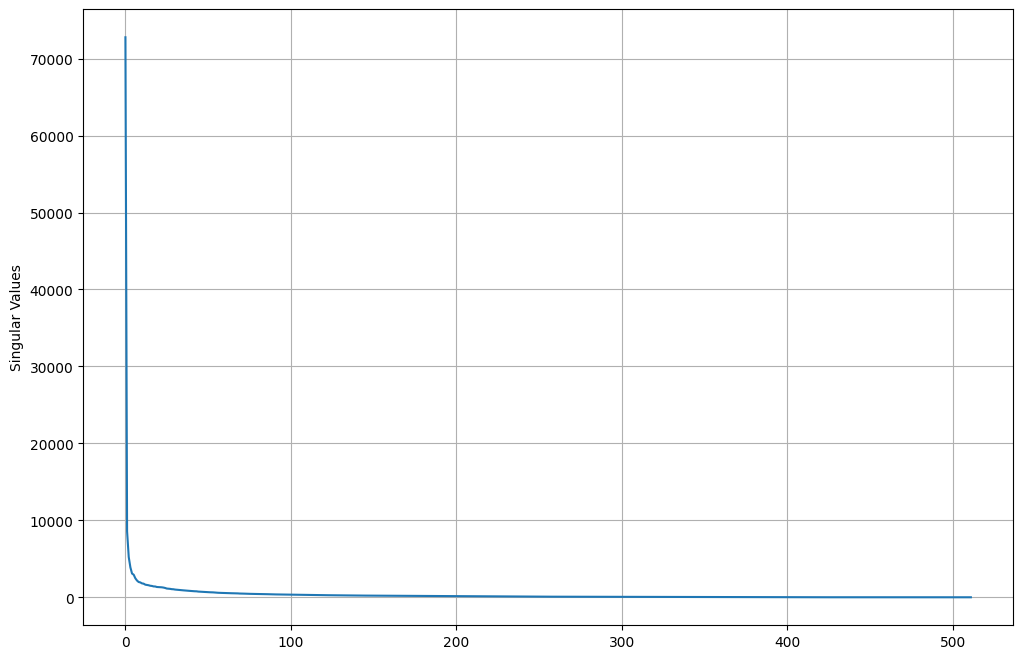

In [26]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(s.shape[0]), np.diagonal(s))
plt.ylabel("Singular Values")
plt.grid()
plt.show()

In [27]:
print(s.shape)

(512, 512)


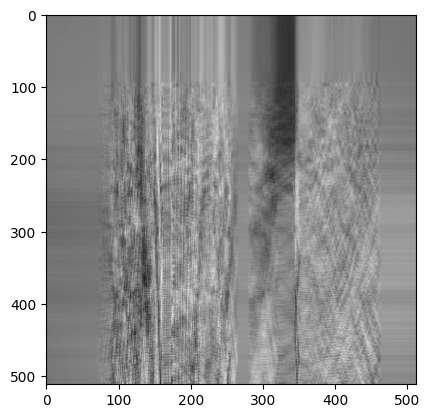

In [28]:
k = 600
U_ = U[:,:k]
S_ = s[:k,:k]
VT_ = VT[:k,:]
new_image = U_ @ S_ @ VT_
#im_norm = new_image - new_image.min()
#im_norm /= (im_norm.max() - im_norm.min() + 1e-9)  # Evita divisioni per zero
plt.imshow(new_image, cmap='gray')
#im = np.clip(new_image,a_min= 0,a_max= 255)
#plt.imshow(new_image, cmap= "gray")

In [29]:
print(new_image.min(), new_image.max())

-57.45445007180961 317.8146484936408


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Carica l'immagine in scala di grigi
#img = cv2.imread(high_res_img, cv2.IMREAD_GRAYSCALE)
#img = img.astype(float)  # Convertire in float per la SVD

# Applicare la SVD
U, S, VT = np.linalg.svd(high_res_img, full_matrices=False)

# Scegli un k ragionevole (es. il 50% dei valori singolari)
k = min(100, len(S))  # Se S ha meno di 700 valori, scegli il massimo disponibile

# Ricostruzione con k valori singolari
U_ = U[:, :k]
S_ = np.diag(S[:k])  # Creare la matrice diagonale corretta
VT_ = VT[:k, :]

new_image = U_ @ S_ @ VT_

# Plot dell'immagine ricostruita
plt.figure(figsize=(4, 4))
plt.imshow(new_image, cmap="gray")
plt.title(f"Ricostruzione con k={k} valori singolari")
plt.axis("off")
plt.show()

NameError: name 'high_res_img' is not defined